In [10]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

import scipy
from PIL import Image
from scipy import ndimage

import torch
import torchvision

from torch import utils
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
import torchvision.models as models

import copy
import time

import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder

from torch.utils.data import DataLoader,Dataset,ConcatDataset
from torchvision.utils import make_grid


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from matplotlib.image import imread

import time
from sklearn.model_selection import train_test_split
from tqdm import tqdm


In [11]:


!mkdir /kaggle/working/Grape
!mkdir /kaggle/working/Grape/test
!mkdir /kaggle/working/Grape/train

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

!cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/test/Grape* /kaggle/working/Grape/test
!cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/train/Grape* /kaggle/working/Grape/train



transfrom = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
    ])

train_path='/kaggle/working/Grape/train'
test_path='/kaggle/working/Grape/test'
BATCH_SIZE=32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
test_dataset=ImageFolder(test_path,transform=transfrom)
train_dataset=ImageFolder(train_path,transform=transfrom)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


# dataset=ImageFolder(path,transform=transfrom)

# train_dataset,test_dataset=train_test_split(dataset,test_size=0.2,shuffle=True,random_state=43)

batch_size = 32
n_iters = 20000
num_epochs = n_iters / (len(train_dataset) / batch_size)

# train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=batch_size, shuffle=True)

# val_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size=batch_size, shuffle=False)

mkdir: cannot create directory ‘/kaggle/working/Grape’: File exists
mkdir: cannot create directory ‘/kaggle/working/Grape/test’: File exists
mkdir: cannot create directory ‘/kaggle/working/Grape/train’: File exists


In [12]:
from torch.autograd import Variable
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.cnn = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(8*56*56, 4)
        
        
    def forward(self, x):
        out = self.cnn(x)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out
    
model = NeuralNetwork()

model = model.to(device)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# iter = 0
# for epoch in range(int(num_epochs)):
#     for i, (images, labels) in enumerate(train_loader):
#         images = Variable(images.cuda())
#         labels = Variable(labels.cuda())
        
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
        
#         iter += 1
        
#         if iter % 500 == 0:
#             correct = 0
#             total = 0
#             for images, labels in test_loader:
#                 images = Variable(images.cuda())
#                 outputs = model(images)
                
#                 _, predicted = torch.max(outputs.data, 1)
#                 total += labels.size(0)
                
#                 if torch.cuda.is_available():
#                     correct += (predicted.cpu() == labels.cpu()).sum()
#                 else:
#                     correct += (predicted == labels).sum()
                
#             accuracy = 100 * correct / total
#             print('Iteration: {}. Loss {}. Accuracy: {}'.format(iter, loss.data, accuracy))

In [13]:
def train(model,loss_fn,dataloader,optimizer,epoch):
  print('\nEpoch : %d'%epoch)
  
  total_loss=0    
  correct=0
  total=0

  model.train()

  for data in tqdm(dataloader):
    
    inputs,labels=data[0].to(device),data[1].to(device)
    
    outputs=model(inputs)
    
    loss=loss_fn(outputs,labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total
  
  accuracies['train'].append(accuracy)
  losses['train'].append(loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(loss,accuracy))

In [14]:
def test(model,loss_fn,dataloader,epoch):
#   model.eval()

  total_loss=0
  correct=0
  total=0

  with torch.no_grad():
    for data in tqdm(dataloader):
      images,labels=data[0].to(device),data[1].to(device)
      
      outputs=model(images)

      loss= loss_fn(outputs,labels)
      total_loss+=loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total

  losses['val'].append(loss)
  accuracies['val'].append(accuracy)

  print('Test Loss: %.3f | Accuracy: %.3f'%(loss,accuracy)) 

In [15]:
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer_ft = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [16]:
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}
# epochs=40
for epoch in range(1,num_epochs+1): 
  train(model,loss_fn,train_loader,optimizer_ft,epoch)
  test(model,loss_fn,val_loader,epoch)


Epoch : 1


100%|██████████| 407/407 [00:44<00:00,  9.04it/s]


Train Loss: 1.262 | Accuracy: 42.018


100%|██████████| 102/102 [00:11<00:00,  8.84it/s]


Test Loss: 1.201 | Accuracy: 46.085

Epoch : 2


100%|██████████| 407/407 [00:44<00:00,  9.08it/s]


Train Loss: 1.072 | Accuracy: 51.069


100%|██████████| 102/102 [00:10<00:00,  9.49it/s]


Test Loss: 1.137 | Accuracy: 50.092

Epoch : 3


100%|██████████| 407/407 [00:47<00:00,  8.62it/s]


Train Loss: 0.957 | Accuracy: 55.275


100%|██████████| 102/102 [00:10<00:00,  9.34it/s]


Test Loss: 0.951 | Accuracy: 52.528

Epoch : 4


100%|██████████| 407/407 [00:47<00:00,  8.60it/s]


Train Loss: 0.850 | Accuracy: 62.696


100%|██████████| 102/102 [00:10<00:00,  9.39it/s]


Test Loss: 0.889 | Accuracy: 58.662

Epoch : 5


100%|██████████| 407/407 [00:46<00:00,  8.71it/s]


Train Loss: 0.755 | Accuracy: 67.125


100%|██████████| 102/102 [00:11<00:00,  8.80it/s]


Test Loss: 0.815 | Accuracy: 60.758

Epoch : 6


100%|██████████| 407/407 [00:46<00:00,  8.67it/s]


Train Loss: 0.704 | Accuracy: 69.786


100%|██████████| 102/102 [00:11<00:00,  8.87it/s]


Test Loss: 0.671 | Accuracy: 70.993

Epoch : 7


100%|██████████| 407/407 [00:45<00:00,  8.88it/s]


Train Loss: 0.669 | Accuracy: 71.624


100%|██████████| 102/102 [00:10<00:00,  9.62it/s]


Test Loss: 0.635 | Accuracy: 73.397

Epoch : 8


100%|██████████| 407/407 [00:45<00:00,  8.87it/s]


Train Loss: 0.650 | Accuracy: 72.139


100%|██████████| 102/102 [00:10<00:00,  9.62it/s]


Test Loss: 0.700 | Accuracy: 68.033

Epoch : 9


100%|██████████| 407/407 [00:45<00:00,  9.01it/s]


Train Loss: 0.631 | Accuracy: 73.277


100%|██████████| 102/102 [00:11<00:00,  8.63it/s]


Test Loss: 0.621 | Accuracy: 71.486

Epoch : 10


100%|██████████| 407/407 [00:45<00:00,  9.04it/s]


Train Loss: 0.606 | Accuracy: 74.254


100%|██████████| 102/102 [00:10<00:00,  9.55it/s]


Test Loss: 0.614 | Accuracy: 71.301

Epoch : 11


100%|██████████| 407/407 [00:46<00:00,  8.78it/s]


Train Loss: 0.591 | Accuracy: 75.062


100%|██████████| 102/102 [00:10<00:00,  9.54it/s]


Test Loss: 0.572 | Accuracy: 75.092

Epoch : 12


100%|██████████| 407/407 [00:45<00:00,  9.01it/s]


Train Loss: 0.585 | Accuracy: 76.138


100%|██████████| 102/102 [00:11<00:00,  8.89it/s]


Test Loss: 0.660 | Accuracy: 72.380

Epoch : 13


100%|██████████| 407/407 [00:45<00:00,  8.90it/s]


Train Loss: 0.566 | Accuracy: 76.038


100%|██████████| 102/102 [00:10<00:00,  9.43it/s]


Test Loss: 0.573 | Accuracy: 77.589

Epoch : 14


100%|██████████| 407/407 [00:46<00:00,  8.72it/s]


Train Loss: 0.555 | Accuracy: 76.961


100%|██████████| 102/102 [00:11<00:00,  9.19it/s]


Test Loss: 0.543 | Accuracy: 77.589

Epoch : 15


100%|██████████| 407/407 [00:46<00:00,  8.78it/s]


Train Loss: 0.539 | Accuracy: 77.738


100%|██████████| 102/102 [00:11<00:00,  9.01it/s]


Test Loss: 0.554 | Accuracy: 78.822

Epoch : 16


100%|██████████| 407/407 [00:47<00:00,  8.65it/s]


Train Loss: 0.530 | Accuracy: 78.553


100%|██████████| 102/102 [00:11<00:00,  8.65it/s]


Test Loss: 0.515 | Accuracy: 80.795

Epoch : 17


100%|██████████| 407/407 [00:46<00:00,  8.81it/s]


Train Loss: 0.510 | Accuracy: 78.783


100%|██████████| 102/102 [00:10<00:00,  9.36it/s]


Test Loss: 0.728 | Accuracy: 68.157

Epoch : 18


100%|██████████| 407/407 [00:46<00:00,  8.67it/s]


Train Loss: 0.507 | Accuracy: 79.452


100%|██████████| 102/102 [00:10<00:00,  9.47it/s]


Test Loss: 0.467 | Accuracy: 82.275

Epoch : 19


100%|██████████| 407/407 [00:45<00:00,  8.90it/s]


Train Loss: 0.496 | Accuracy: 80.475


100%|██████████| 102/102 [00:10<00:00,  9.68it/s]


Test Loss: 0.571 | Accuracy: 77.528

Epoch : 20


100%|██████████| 407/407 [00:45<00:00,  9.00it/s]


Train Loss: 0.496 | Accuracy: 80.037


100%|██████████| 102/102 [00:10<00:00,  9.64it/s]


Test Loss: 0.540 | Accuracy: 77.219

Epoch : 21


100%|██████████| 407/407 [00:46<00:00,  8.84it/s]


Train Loss: 0.484 | Accuracy: 80.552


100%|██████████| 102/102 [00:10<00:00,  9.63it/s]


Test Loss: 0.545 | Accuracy: 76.819

Epoch : 22


100%|██████████| 407/407 [00:45<00:00,  8.92it/s]


Train Loss: 0.476 | Accuracy: 81.275


100%|██████████| 102/102 [00:10<00:00,  9.40it/s]


Test Loss: 0.612 | Accuracy: 72.534

Epoch : 23


100%|██████████| 407/407 [00:45<00:00,  8.96it/s]


Train Loss: 0.478 | Accuracy: 80.775


100%|██████████| 102/102 [00:11<00:00,  8.90it/s]


Test Loss: 0.416 | Accuracy: 83.909

Epoch : 24


100%|██████████| 407/407 [00:44<00:00,  9.05it/s]


Train Loss: 0.464 | Accuracy: 81.114


100%|██████████| 102/102 [00:10<00:00,  9.58it/s]


Test Loss: 0.534 | Accuracy: 77.928

Epoch : 25


100%|██████████| 407/407 [00:45<00:00,  8.90it/s]


Train Loss: 0.468 | Accuracy: 81.444


100%|██████████| 102/102 [00:10<00:00,  9.49it/s]


Test Loss: 0.749 | Accuracy: 67.725

Epoch : 26


100%|██████████| 407/407 [00:45<00:00,  8.99it/s]


Train Loss: 0.455 | Accuracy: 81.952


100%|██████████| 102/102 [00:11<00:00,  8.85it/s]


Test Loss: 0.410 | Accuracy: 83.354

Epoch : 27


100%|██████████| 407/407 [00:45<00:00,  8.98it/s]


Train Loss: 0.456 | Accuracy: 81.821


100%|██████████| 102/102 [00:10<00:00,  9.59it/s]


Test Loss: 0.474 | Accuracy: 80.117

Epoch : 28


100%|██████████| 407/407 [00:46<00:00,  8.83it/s]


Train Loss: 0.456 | Accuracy: 82.113


100%|██████████| 102/102 [00:10<00:00,  9.68it/s]


Test Loss: 0.410 | Accuracy: 83.909

Epoch : 29


100%|██████████| 407/407 [00:44<00:00,  9.06it/s]


Train Loss: 0.454 | Accuracy: 82.075


100%|██████████| 102/102 [00:11<00:00,  8.71it/s]


Test Loss: 0.617 | Accuracy: 74.383

Epoch : 30


100%|██████████| 407/407 [00:45<00:00,  8.99it/s]


Train Loss: 0.446 | Accuracy: 82.267


100%|██████████| 102/102 [00:10<00:00,  9.52it/s]


Test Loss: 0.463 | Accuracy: 80.487

Epoch : 31


100%|██████████| 407/407 [00:46<00:00,  8.77it/s]


Train Loss: 0.444 | Accuracy: 82.290


100%|██████████| 102/102 [00:10<00:00,  9.54it/s]


Test Loss: 0.388 | Accuracy: 85.604

Epoch : 32


100%|██████████| 407/407 [00:46<00:00,  8.82it/s]


Train Loss: 0.435 | Accuracy: 82.767


100%|██████████| 102/102 [00:10<00:00,  9.58it/s]


Test Loss: 0.412 | Accuracy: 83.354

Epoch : 33


100%|██████████| 407/407 [00:45<00:00,  8.92it/s]


Train Loss: 0.435 | Accuracy: 82.751


100%|██████████| 102/102 [00:11<00:00,  8.85it/s]


Test Loss: 0.415 | Accuracy: 83.200

Epoch : 34


100%|██████████| 407/407 [00:45<00:00,  9.04it/s]


Train Loss: 0.426 | Accuracy: 83.067


100%|██████████| 102/102 [00:10<00:00,  9.61it/s]


Test Loss: 0.419 | Accuracy: 84.556

Epoch : 35


100%|██████████| 407/407 [00:45<00:00,  8.89it/s]


Train Loss: 0.431 | Accuracy: 82.851


100%|██████████| 102/102 [00:10<00:00,  9.59it/s]


Test Loss: 0.417 | Accuracy: 84.957

Epoch : 36


100%|██████████| 407/407 [00:45<00:00,  9.02it/s]


Train Loss: 0.427 | Accuracy: 82.851


100%|██████████| 102/102 [00:11<00:00,  8.83it/s]


Test Loss: 0.412 | Accuracy: 85.049

Epoch : 37


100%|██████████| 407/407 [00:45<00:00,  9.02it/s]


Train Loss: 0.422 | Accuracy: 82.936


100%|██████████| 102/102 [00:10<00:00,  9.59it/s]


Test Loss: 0.412 | Accuracy: 84.217

Epoch : 38


100%|██████████| 407/407 [00:46<00:00,  8.84it/s]


Train Loss: 0.423 | Accuracy: 83.336


100%|██████████| 102/102 [00:10<00:00,  9.52it/s]


Test Loss: 0.410 | Accuracy: 84.340

Epoch : 39


100%|██████████| 407/407 [00:46<00:00,  8.79it/s]


Train Loss: 0.423 | Accuracy: 83.098


100%|██████████| 102/102 [00:10<00:00,  9.59it/s]


Test Loss: 0.367 | Accuracy: 86.683

Epoch : 40


100%|██████████| 407/407 [00:45<00:00,  8.94it/s]


Train Loss: 0.423 | Accuracy: 83.436


100%|██████████| 102/102 [00:11<00:00,  8.87it/s]

Test Loss: 0.393 | Accuracy: 85.419


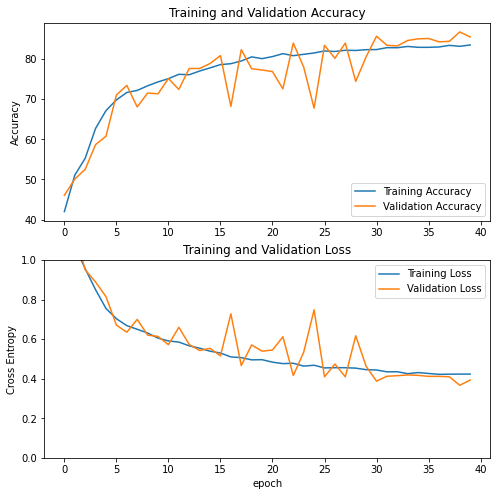

In [17]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracies['train'], label='Training Accuracy')
plt.plot(accuracies['val'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(losses['train'], label='Training Loss')
plt.plot(losses['val'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [18]:
# import os, os.path

# # simple version for working with CWD
# print len([name for name in os.listdir('') if os.path.isfile(name)])

SyntaxError: invalid syntax (950457019.py, line 4)